<a href="https://colab.research.google.com/github/HumbertoMtzBta/Anlisis-de-redes-sociales-con-igraph/blob/main/Copia_de_toponym_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install geopandas
!pip3 install python-geohash
!pip3 install polygon_geohasher
!pip3 install haversine
!pip3 install contextily

In [ ]:
# ================================================
# Create Geo Pandas DataFrame and structures
# ================================================
import geopandas as gpd
from polygon_geohasher.polygon_geohasher import geohash_to_polygon
from shapely.geometry import Polygon, box
# ================================================
# Geohashing and haversine distances
# ================================================
from haversine import haversine, Unit
import geohash as gh
GEOHASH_PRECISION = 7
# ================================================
# Plot Map
# ================================================
import contextily as ctx
import matplotlib.cm as cm
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# ================================================
# load & store data and results
# ================================================
from google.colab import drive
import json

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cd "/content/drive/MyDrive/CIMAT-CENTROGEO NLP/topónimos/data"
DATADIR = "/content/drive/MyDrive/CIMAT-CENTROGEO NLP/topónimos/data/"

In [ ]:
def KeyError_catcher(loc, label):
    try:
        v = loc[label]
    except Exception as e:
        v = ''
    return v

def as_geometry(bb_coordinates):
    #['19.2726009', '19.5926009', '-99.2933416', '-98.9733416']
    ###
    sin_bb = [float(s) for s in bb_coordinates]
    [s, n, w, e] = sin_bb
    bbox = [w,s,e,n]
    polygon = box(*bbox)
    return(polygon)

def build_df(j_path):
    tmp_list = []
    bname = (j_path.split('/')[-1]).split('.')[0]
    with open(j_path) as f:
        j = json.load(f)
        data = j["data"]
        text = data[0]["labeled"]
        entities = data[0]["entities"]
        n_ents = len(entities)
        #print('\n\t {}\n'.format(bname))
        #print('{}'.format(text))
        #print('\t{} Geographic Entities found'.format(n_ents))        
        for i,e in enumerate(entities):
            local_idx = 0
            points_coords = []
            ent_index = int(e["index"])
            entity = e["entity"]
            correct = int(e["select"])
            #print('\n'+entity)
            for j,l in enumerate(e["locations"]):
                lat = float(KeyError_catcher(l,"lat"))
                lon = float(KeyError_catcher(l,"lon"))
                bbox = as_geometry(KeyError_catcher(l, "boundingbox"))
                cat = KeyError_catcher(l,"category")
                dname = KeyError_catcher(l,"display_name")
                detail  = KeyError_catcher(l,"namedetails")
                osm_type =  KeyError_catcher(l,"osm_type")
                osm_placeid =  KeyError_catcher(l,"place_id")
                osm_placerank = int(KeyError_catcher(l,"place_rank"))
                osmtype = KeyError_catcher(l,"type")
                if j==correct:
                    groud_t = 'T'
                else:
                    groud_t = ' '
                latlon = '' if lat=='' else '{},{}'.format(round(float(lat), 6),
                    round(float(lon), 6))
                havebbox = '' if bbox=='' else bbox
                s = '{}|{}|{}| {} |{}|{}|{}|{} {} {}'.format(groud_t,ent_index,local_idx,latlon,havebbox,osm_placerank,dname,cat,osmtype, osm_type)
                #print(s)
                tmp_list.append({                    
                    'bname':bname,
                    'ename': entity,
                    'ent_index': ent_index,
                    'local_idx': local_idx,
                    'lat': lat,
                    'lon': lon,
                    'geometry': bbox,
                    'osm_placerank': osm_placerank,
                    'dname': dname,
                    'fulltext': text,
                })
                local_idx+=1
        #print('\n')
    gdf = gpd.GeoDataFrame(tmp_list)
    gdf.set_crs(epsg = 4326, inplace=True)
    return(gdf)

def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color


def pickacolor(i):
    colors=[mcolors.TABLEAU_COLORS[color] for color in mcolors.TABLEAU_COLORS]
    return(colors[i])

def mapplot(geodf):
    # Convert the data to Web Mercator
    # Web map tiles are typically provided in Web Mercator (EPSG 3857), so we need to make sure to convert our data first to the same CRS to combine our polygons and background tiles in the same map:
    try:
        CRS_df = geodf.to_crs(epsg=3857)
        #print(CRS_df)
    except Exception as e:
        raise e

    # # we are using an extent around Mexico for the examples
    extent = (-13100000, -9700000, 1600000, 3800000)
    ax = CRS_df.plot(figsize=(20, 12), alpha=0.3, edgecolor='w')
    CRS_df.apply(lambda x: ax.annotate(s=str(x.osm_placerank)+'\n'+x.ename,
                                       xy=x.geometry.centroid.coords[0],
                                       ha='center',
                                       color=pickacolor(x.ent_index),
                                       size=7.5,
                                       ),
                 axis=1);
    ax.axis(extent)
    #ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)
    plt.axis('off')
    plt.show()

In [ ]:
j_path = DATADIR+"elgrafico201.json"
gd = build_df(j_path)

          bname             ename  ent_index  local_idx        lat  \
0  elgrafico201  Ciudad de México          1          0  19.432601   
1  elgrafico201  Ciudad de México          1          1  19.320556   
2  elgrafico201  Ciudad de México          1          2  18.150882   
3  elgrafico201  Ciudad de México          1          3  19.290484   
4  elgrafico201  Ciudad de México          1          4  19.399705   
5  elgrafico201           Sinaloa          4          0  25.000000   
6  elgrafico201           Sinaloa          4          1  26.020108   
7  elgrafico201           Sinaloa          4          2  16.598090   
8  elgrafico201           Sinaloa          4          3  30.734833   
9  elgrafico201           Sinaloa          4          4  24.768183   

          lon                                           geometry  \
0  -99.133342  POLYGON ((-98.97334 19.27260, -98.97334 19.592...   
1  -99.151701  POLYGON ((-98.94030 19.04824, -98.94030 19.592...   
2  -94.515681  POLYGON ((

TypeError: ignored

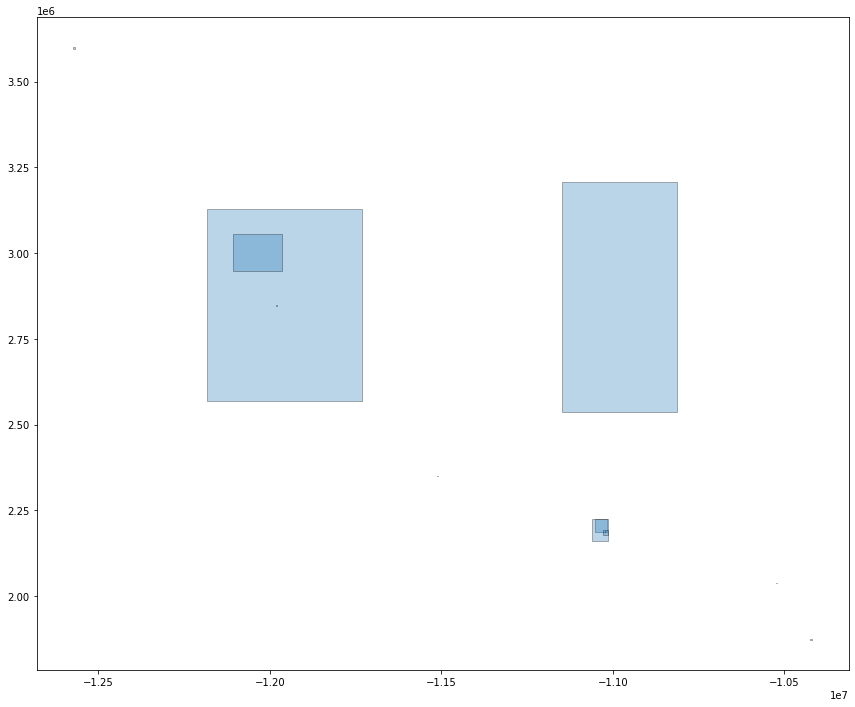

In [ ]:
print(gd.head(10))
mapplot(gd)

In [ ]:
Latitud=19.443302084457635
Longitud=-99.12963656583918
gh_code = gh.encode(Latitud, Longitud, precision = GEOHASH_PRECISION)
print(gh_code, type(gh_code))

bb = gh.bbox(gh_code)
print(bb)
bb_vertexes = [(bb['s'], bb['w']), (bb['n'], bb['w']), (bb['n'], bb['e']), (bb['s'], bb['e'],)]
bb_vertexes

# Distancias del lado SW-SE
print("Distancia SW-SE:",round(haversine(bb_vertexes[0], bb_vertexes[3], unit = Unit.METERS),3),"mts")

# Distancias del lado SW-NW
print("Distancia SW-NW:",round(haversine(bb_vertexes[0], bb_vertexes[1], unit = Unit.METERS),3),"mts")

# Distancia diagonal (SW-NE)
print("Distancia SW-NE (diagonal):", round(haversine(bb_vertexes[0], bb_vertexes[2], unit = Unit.METERS),3), "mts")

9g3w878 <class 'str'>
{'s': 19.44305419921875, 'w': -99.129638671875, 'n': 19.444427490234375, 'e': -99.12826538085938}
Distancia SW-SE: 143.995 mts
Distancia SW-NW: 152.703 mts
Distancia SW-NE (diagonal): 209.887 mts


In [ ]:


gdf = gpd.GeoDataFrame({'location':[(Latitud,Longitud) , (19.445545, -99.1273622), (20.6543957,-103.4394312)]})

gdf['geohash'] = gdf['location'].apply(lambda x: gh.encode(x[0], x[1], GEOHASH_PRECISION))
gdf['geometry'] = gdf['geohash'].apply(geohash_to_polygon)
gdf.set_crs(epsg = 4326, inplace=True)
#gdf.set_crs(epsg = 3857, inplace=True)



,location,geohash,geometry
0,"(19.443302084457635, -99.12963656583918)",9g3w878,"POLYGON ((-99.12964 19.44305, -99.12827 19.443..."
1,"(19.445545, -99.1273622)",9g3w87c,"POLYGON ((-99.12827 19.44443, -99.12689 19.444..."
2,"(20.6543957, -103.4394312)",9ewmw0j,"POLYGON ((-103.44040 20.65430, -103.43903 20.6..."


In [ ]:
sinaloa_bb = [22.4671337, 27.0422491, -109.447584, -105.39222]
[s, n, w, e] = sinaloa_bb
print(s,n,w,e)
bbox = [w,s,e,n]
polygon = box(*bbox)
print(polygon)
gdf_sinaloa_bb = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])
gdf_sinaloa_bb['dname']="Sinaloa"
print(gdf_sinaloa_bb['geometry'])

22.4671337 27.0422491 -109.447584 -105.39222
POLYGON ((-105.39222 22.4671337, -105.39222 27.0422491, -109.447584 27.0422491, -109.447584 22.4671337, -105.39222 22.4671337))
0    POLYGON ((-105.39222 22.46713, -105.39222 27.0...
Name: geometry, dtype: geometry


In [ ]:
import contextily as ctx
import matplotlib.pyplot as plt

def mapplot(geodf):
    # Convert the data to Web Mercator
    # Web map tiles are typically provided in Web Mercator (EPSG 3857), so we need to make sure to convert our data first to the same CRS to combine our polygons and background tiles in the same map:
    try:
        CRS_df = geodf.to_crs(epsg=3857)
        #print(CRS_df)
    except Exception as e:
        raise e

    # # we are using an extent around Mexico for the examples
    extent = (-13100000, -9700000, 1600000, 3800000)
    ax = CRS_df.plot(figsize=(20, 12), alpha=0.3, edgecolor='k')
    CRS_df.apply(lambda x: ax.annotate(s=x.dname, xy=x.geometry.centroid.coords[0], ha='center', color='k'), axis=1);
    ax.axis(extent)
    #ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)    
    #ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    #ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)
    #ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainBackground)
    #ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerBackground)
    #ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels)
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)
    plt.axis('off')
    plt.show()

TypeError: ignored

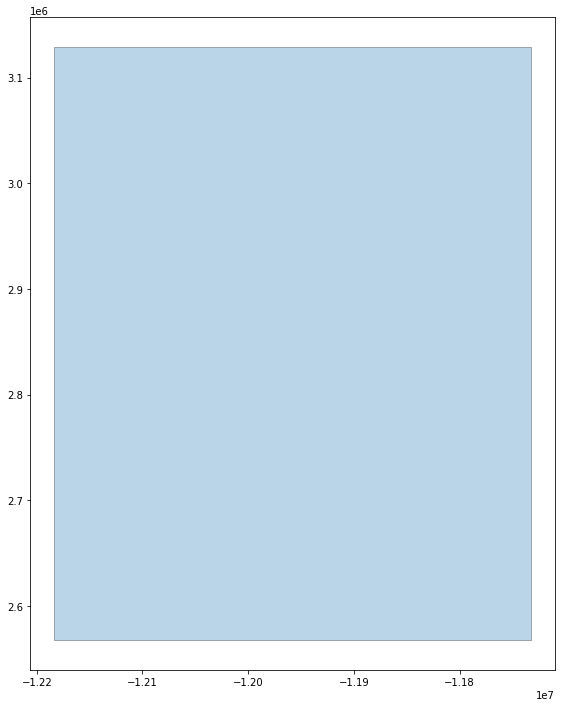

In [ ]:
mapplot(gdf_sinaloa_bb)

In [ ]:
import matplotlib.colors as mcolors

print(mcolors.TABLEAU_COLORS)
colors=[mcolors.TABLEAU_COLORS[color] for color in mcolors.TABLEAU_COLORS]
print(colors)
print(colors[2])

https://aclanthology.org/S19-2155.pdf
